In [169]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
import scipy.stats as st
from sksurv.nonparametric import kaplan_meier_estimator
from scipy.stats import ttest_ind
from sklearn.metrics import r2_score 
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings("ignore")

import os
%matplotlib inline

# load parameters into data frame
parameters_file = r'/Users/kowens2/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Monolix/NBA Cohort/Projects/FitAllInfectionsAppendNegatives/T0_1x107_E0_0_I0_0_V0_est/IndividualParameters/estimatedIndividualParameters.txt'
parameters_df = pd.read_csv(parameters_file)

# load data into data frame
data_file = r'/Users/kowens2/Library/CloudStorage/OneDrive-FredHutchinsonCancerResearchCenter/Monolix/NBA Cohort/Data/NBA_all_1500.csv'
data_df = pd.read_csv(data_file)

# list unique infection IDs
IDs = parameters_df.id.unique()

In [68]:
# -- Define functions for pulling in model parameters and simulating 

def GetParams(parameters_df, ID, style = 'mode'):
    ''' 
    input:
        - data frame with parameter values as columns, individuals as rows
        - ID identifying individual of interest
        - style = 'mode' or 'mean' or 'SAEM' depending on which parameter values are preferred
    return:
        - dictionary with parameter names as key and parameter values as values
    '''
    i = ID
    cols = list(parameters_df)
    pid_params = parameters_df[parameters_df.id == i].copy()
    values = []
    keys = []
    for c in cols:
        if style in c:
            k = c.split('_')[0]
            keys.append(k)
            v = pid_params[c].values[0]
            values.append(v)
        for i,(v,k) in enumerate(zip(values, keys)):
            if 'log10' in k:
                values[i] = 10**v
                keys[i] = k.split('0')[1]

    params = dict(zip(keys, values))
    return params

def Simulate(func, param_order, param_dict, init, tend, N):
    '''
    input: 
        - func is a function that takes in the state variable, time and parameters and returns the derivative
        - params is a dictionary of the parameter values 
        - init is a dictionary of the initial condition to simulate from 
    return: 
        - trajectory simulated from init for tspan using func with given params
    '''
    # make parameter list in correct order
    params = []
    for k in param_order:
        params.append(param_dict[k])
    # extract initial time
    if 'tzero' in param_dict:
        t0 = -param_dict['tzero']
    else:
        t0 = 0 
    # build tspan
    tspan = np.linspace(t0,tend,N)
    init[4] = param_dict['V0']

    # simulate using scipy integrate
    y = spi.odeint(func, init, tspan, args = tuple(params))
    return tspan,y

# Put fixed paramters in a dictionary
fixed_params = dict({'c': 15,'k':4})
# set initial conditions
T_0 = 10**7
R_0 = 0;
E_0 = 0;
I_0 = 0
V_0 = 0; # -- will be overwritten with estimated value
init = [T_0, R_0, E_0, I_0, V_0]

# Write function for model simulation
def deriv(y, t, beta, phi, rho, k, delta,h, m, pi, c,tAI):
    T,R,E,I,V = y
    
    if t > tAI:
        eps = m
    else:
        eps = 0
        
    ddt_T = -beta*T*V - phi*I*T + rho*R
    ddt_R = phi*I*T -rho*R
    ddt_E = beta*T*V - k*E
    ddt_I = k*E - delta*np.maximum(I,.000001)**h*I - eps*I # I^h gets too small when I is small, so set a lower bound
    ddt_V = pi*I-c*V

    return ddt_T, ddt_R, ddt_E, ddt_I, ddt_V

param_order = ['beta', 'phi', 'rho', 'k', 'delta','h', 'm', 'pi', 'c', 'tAI']

In [69]:
# Pull out individuals who have a pair of 1st and 2nd infection documented

L2 = []
L1 = []
for i in IDs:
    if i.split('_')[1] == '1':
        L1.append(i.split('_')[0])
    if i.split('_')[1] == '2':
        L2.append(i.split('_')[0])
pids = list(set(L1).intersection(set(L2)))
print(len(pids))

67


### Plot viral load data and model simulations

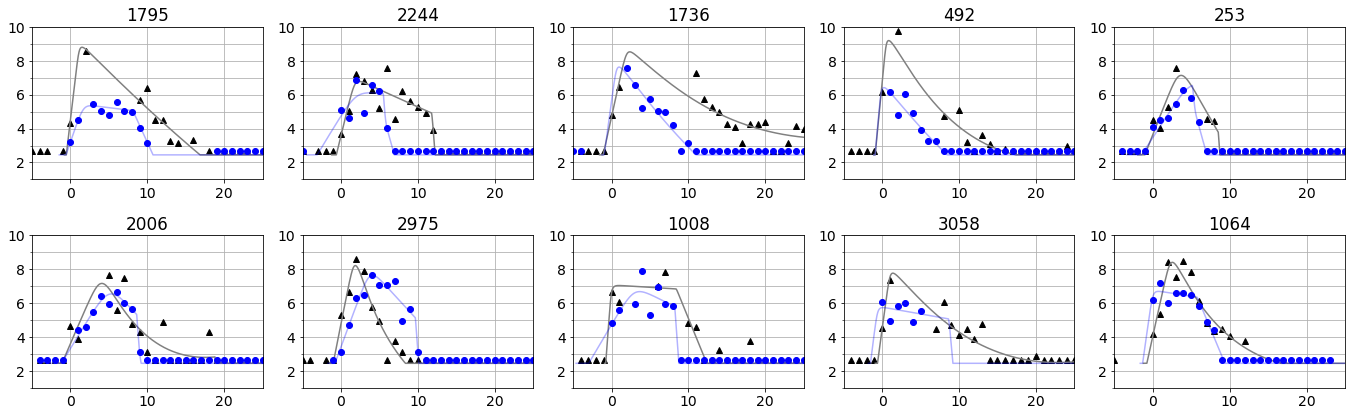

In [73]:
# Plot some examples for main figure
fig5= ['1795', '2244','1736','492','253', '2006','2975','1008','3058','1064','2310']   

plt.rcParams.update({'font.size': 14})
count = 0
fig, ax = plt.subplots(2,5, figsize =(19,6))
for j in range(0,2):
    for jj in range(0,5):
        if count < len(pids):
            # -- 1st infection
            ID = fig5[count]+'_1'
            # simulate
            ind_params = GetParams(parameters_df, ID, style = 'mode')
            params_dict = {**fixed_params, **ind_params}
            t,y = Simulate(deriv, param_order, params_dict, init, 50+params_dict['tzero'], 10000)
            # pull data
            tdata = data_df[data_df['ID'] == ID].time
            temp = data_df[data_df['ID'] == ID].y
            ydata = [float(y) for y in temp]
            # plot
            ax[j,jj].plot(tdata.values, ydata,'^', color = 'black')
            ax[j,jj].plot(t, np.log10(np.maximum(y[:,4],280)), color = 'gray')
            
            # -- 2nd infection
            ID = fig5[count]+'_2'
            # simulate
            ind_params = GetParams(parameters_df, ID, style = 'mode')
            params_dict = {**fixed_params, **ind_params}
            t,y = Simulate(deriv, param_order, params_dict, init, 50+params_dict['tzero'], 10000)
            # pull data
            tdata = data_df[data_df['ID'] == ID].time
            temp = data_df[data_df['ID'] == ID].y
            ydata = [float(y) for y in temp]
            # plot
            ax[j,jj].plot(tdata.values, ydata,'o', color = 'blue')
            ax[j,jj].plot(t, np.log10(np.maximum(y[:,4],280)), color = 'blue',alpha = 0.3)
            
            # -- Format the plot
            ax[j,jj].set_ylim(1,10)
            ax[j,jj].set_title(ID.split('_')[0])
            major_ticks = np.arange(2, 11, 2)
            minor_ticks = np.arange(1, 11, 1)
            ax[j,jj].set_yticks(major_ticks)
            ax[j,jj].set_yticks(minor_ticks, minor=True)
            ax[j,jj].grid(which='both')
            ax[j,jj].set_xlim(-5,25)
            
            # -- Next
            count = count+1

plt.tight_layout()

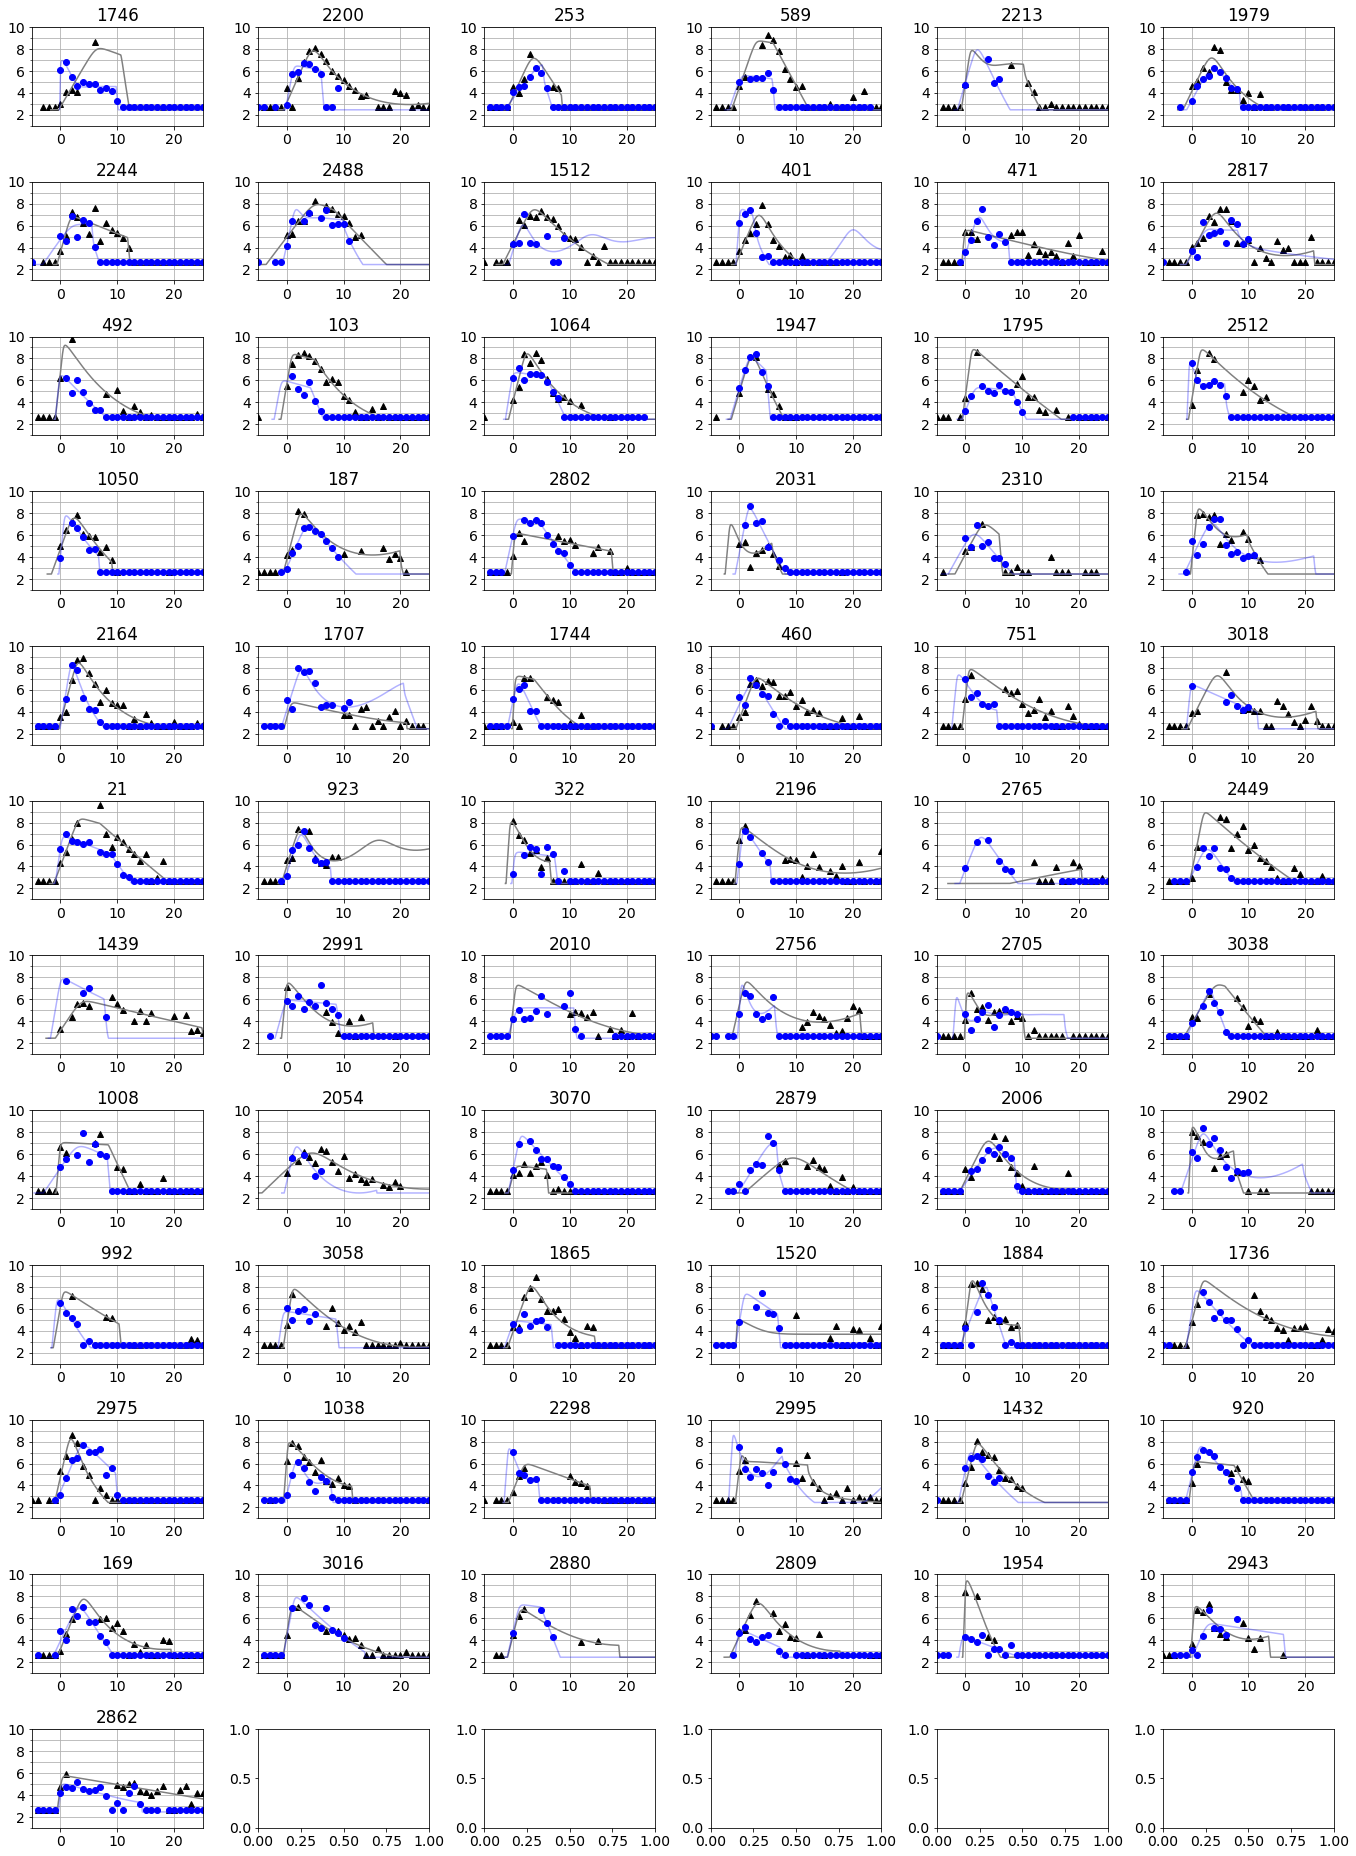

In [74]:
# -- Plot all cases for supplement

plt.rcParams.update({'font.size': 14})
count = 0
fig, ax = plt.subplots(12,6, figsize =(19,26))
for j in range(0,12):
    for jj in range(0,6):
        if count < len(pids):
            # -- 1st infection
            ID = pids[count]+'_1'
            # simulate
            ind_params = GetParams(parameters_df, ID, style = 'mode')
            params_dict = {**fixed_params, **ind_params}
            t,y = Simulate(deriv, param_order, params_dict, init, 50+params_dict['tzero'], 10000)
            # pull data
            tdata = data_df[data_df['ID'] == ID].time
            temp = data_df[data_df['ID'] == ID].y
            ydata = [float(y) for y in temp]
            # plot
            ax[j,jj].plot(tdata.values, ydata,'^', color = 'black')
            ax[j,jj].plot(t, np.log10(np.maximum(y[:,4],280)), color = 'gray')
            
            # -- 2nd infection
            ID = pids[count]+'_2'
            # simulate
            ind_params = GetParams(parameters_df, ID, style = 'mode')
            params_dict = {**fixed_params, **ind_params}
            t,y = Simulate(deriv, param_order, params_dict, init, 50+params_dict['tzero'], 10000)
            # pull data
            tdata = data_df[data_df['ID'] == ID].time
            temp = data_df[data_df['ID'] == ID].y
            ydata = [float(y) for y in temp]
            # plot
            ax[j,jj].plot(tdata.values, ydata,'o', color = 'blue')
            ax[j,jj].plot(t, np.log10(np.maximum(y[:,4],280)), color = 'blue',alpha = 0.3)
            
            # -- Format the plot
            ax[j,jj].set_ylim(1,10)
            ax[j,jj].set_title(ID.split('_')[0])
            major_ticks = np.arange(2, 11, 2)
            minor_ticks = np.arange(1, 11, 1)
            ax[j,jj].set_yticks(major_ticks)
            ax[j,jj].set_yticks(minor_ticks, minor=True)
            ax[j,jj].grid(which='both')
            ax[j,jj].set_xlim(-5,25)
            
            # -- Next
            count = count+1
plt.tight_layout()

### Quantitative differences between infection and reinfection data

(1) Peak viral load

In [99]:
IDs = [p +'_1' for p in pids] + [p +'_2' for p in pids]
list1 = []
list2=[]
for i in [p +'_1' for p in pids]:
    y = data_df[data_df.ID ==i].y.copy()
    list1.append(np.max(y))
for i in [p +'_2' for p in pids]:
    y = data_df[data_df.ID ==i].y.copy()
    list2.append(np.max(y))

Ttest_indResult(statistic=2.2603173739319162, pvalue=0.025439009776892358)
difference in means: 0.41076968329062247


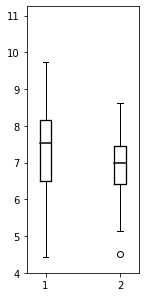

In [101]:
# Make a box plot
fig, ax = plt.subplots(1,1, figsize = (2,4.9))
all_data= [list1,list2]
boxprops = dict(color="black",linewidth=1.3)
medianprops = dict(color="black",linewidth=1.5)

ax.boxplot(all_data, labels=['1','2'],boxprops=boxprops, medianprops=medianprops);
ax.set_xlim([.75, 2.25])
ax.set_ylim([4, 11.25])
pairs = [(1,2)]
x1, x2 = 1, 2
h = .2
print(ttest_ind(list1,list2))
print('difference in means: ' +str(np.mean(list1)-np.mean(list2)))

In [102]:
Reinfection_flag = []
PeakVL = []
for i in parameters_df.id.unique():
    y = data_df[data_df.ID ==i].y.copy()
    PeakVL.append(np.max(y))
    if i in IDs:
        if i.split('_')[1] == '1':
            Reinfection_flag.append(1)
        else:
            Reinfection_flag.append(2)
    else: 
        Reinfection_flag.append(0)

parameters_df['Peak'] = PeakVL
parameters_df['ReinfectionFlag'] = Reinfection_flag
reinfections_df = parameters_df[parameters_df['ReinfectionFlag']>0].copy()

rho = -0.17830159077166677 p =  0.1488537843452099
slope = [-0.12275557] R2 = 0.03179145727170704
intercept = 7.777541853112694


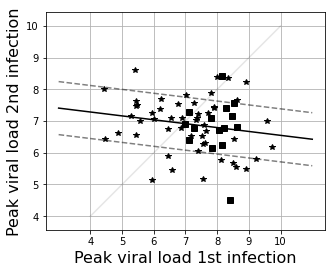

In [103]:
list1vars = []
list2vars =[]
for i in [p +'_1' for p in pids]:
    list1vars.append(list(reinfections_df[reinfections_df.id==i].cat_LineageBroad)[0])
for i in [p +'_2' for p in pids]:
    list2vars.append(list(reinfections_df[reinfections_df.id ==i].cat_LineageBroad)[0])


rho,p = pearsonr(list1, list2)
print('rho = '+str(rho), 'p = ', str(p) )


colorDict={ 'Delta': 'black', 'Other': 'black'}
shapeDict={'Delta':'s', 'Other':'*'}

fig, ax = plt.subplots(1,1, figsize  = (5,4) )
ax.grid()
plt.plot(np.arange(4,11),np.arange(4,11),'k', alpha = .1)
for i,(l1,l2) in enumerate(zip(list1vars,list2vars)):
    ax.plot(list1[i], list2[i], color = colorDict[l1], marker = shapeDict[l1])

ax.set_xlabel('Peak viral load 1st infection', fontsize = 16)
ax.set_ylabel('Peak viral load 2nd infection', fontsize = 16)

from sklearn.linear_model import LinearRegression
x = np.array(list1).reshape((-1, 1))
y = np.array(list2)
model = LinearRegression().fit(x,y)
stdev = np.sqrt(sum((model.predict(x) - y)**2) / (len(y) - 2))
x_new = np.arange(3,12).reshape((-1, 1))
y_new = model.predict(x_new)
plt.plot(x_new,y_new, 'k')
plt.plot(np.arange(3,12), y_new+stdev,'k--', alpha = .5)
plt.plot(np.arange(3,12), y_new-stdev,'k--', alpha = .5)
ax.axis('equal')
ax.set_xticks(np.arange(4,11));
ax.set_yticks(np.arange(4,11));
ax.set_ylim(4,10);
corr_matrix = np.corrcoef(np.array(list2), model.predict(np.array(list1).reshape((-1,1))))
corr = corr_matrix[0,1]
R_sq = corr**2
print('slope = '+ str(model.coef_),'R2 = '+str(R_sq))
print('intercept = '+ str(model.intercept_))

(2) AUC

1st infections: 158.00481787587543
2nd infections: 119.61306872707304


Text(0, 0.5, 'count')

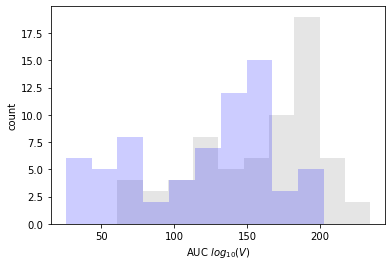

In [105]:
from sklearn.metrics import auc

list1 = []
list2=[]
for i in [p +'_1' for p in pids]:
    y = data_df[data_df.ID ==i].y.copy()
    t = data_df[data_df.ID ==i].time.copy()
    list1.append(auc(t,y))
for i in [p +'_2' for p in pids]:
    y = data_df[data_df.ID ==i].y.copy()
    t = data_df[data_df.ID ==i].time.copy()
    list2.append(auc(t,y))
    
plt.hist(list1, color = 'tab:gray', alpha = .2)
print('1st infections: ' +str(np.mean(list1)))
plt.hist(list2, color = 'blue', alpha = .2)
print('2nd infections: ' +str(np.mean(list2)))
plt.xlabel(r'AUC $log_{10}(V)$')
plt.ylabel('count')

# Not as meaningful to calculate AUC directly from the data 
# because a number of the reinfections are not documented through elimination

(3) Time to clearance

In [124]:
# -- make cumulative incidence curves
from sksurv.nonparametric import kaplan_meier_estimator
def AddRegressorColumn(df, func, ColumnLabel):
    PIDs = df.ID.unique()
    NewCol = []
    for i,p in enumerate(PIDs):
        df_ind = df.loc[df.ID == p,:]
        value = func(df_ind)
        NumRows = len(df_ind)
        x = list(np.repeat(value,NumRows))
        NewCol.extend(x)
    df[ColumnLabel] = NewCol
    return None

def IsReinfection(row):
    i = list(row.ID)[0]
    if i in IDs:
        if i.split('_')[1] == '1':
            ret = 1
        else:
            ret = 2
    else: 
        ret = 0
    return ret

AddRegressorColumn(data_df, IsReinfection, 'ReinfectionFlag')
def CalculateClearedProportion(df,thresh):
    time_observed = []
    status = []

    for i,inf in enumerate(df.ID.unique()):
        df_id = df[df['ID']==inf]
        try:
            t = np.array(df_id[df_id.time >=0].time)
            y = np.array(df_id[df_id.time >=0].y) 
            date_measured = t[y<=thresh][0]
            clearance_indicator = True
        except:
            date_measured = t[-1]
            clearance_indicator = False
        time_observed.append(date_measured)
        status.append(clearance_indicator)
        
    time, survival_prob, CI = kaplan_meier_estimator(status, time_observed, conf_type='log-log')
    return time, survival_prob, CI

Median time to clearance 1st infection: 14 days
Median time to clearance 2nd infection: 9 days
Difference: 5 days


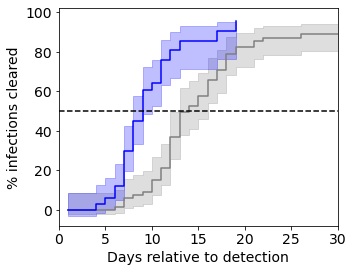

In [125]:
df_1 = data_df[data_df['ReinfectionFlag']==1].copy()
df_2 = data_df[data_df['ReinfectionFlag']==2].copy()

thresh = 2.6576096821516124
time1, survival_prob1, CI1 = CalculateClearedProportion(df_1,thresh)
M1 = time1[np.argwhere(100*(1-survival_prob1-(1-survival_prob1[0]))>=50)[0][0]]
time2, survival_prob2, CI2 = CalculateClearedProportion(df_2,thresh)
M2 = time2[np.argwhere(100*(1-survival_prob2-(1-survival_prob2[0]))>=50)[0][0]]

fig, axs = plt.subplots(figsize = (5,4))
plt.rcParams.update({'font.size': 14})

plt.step(time1, 100*(1-survival_prob1-(1-survival_prob1[0])), where="post", color = 'tab:gray', label = '1')
plt.fill_between(time1, 100*(1-CI1[0]-(1-survival_prob1[0])), 100*(1-CI1[1]-(1-survival_prob1[0])), color = 'tab:gray', alpha=0.25, step="post")
plt.step(time2, 100*(1-survival_prob2-(1-survival_prob2[0])), where="post", color = 'blue', label = '2')
plt.fill_between(time2, 100*(1-CI2[0]-(1-survival_prob2[0])), 100*(1-CI2[1]-(1-survival_prob2[0])), color = 'blue', alpha=0.25, step="post")
plt.plot([0,30],[50,50],'k--')
plt.xlim([0,30])
plt.xlabel('Days relative to detection')
plt.ylabel('% infections cleared')
print('Median time to clearance 1st infection: '+str(M1) +' days' )
print('Median time to clearance 2nd infection: '+str(M2) +' days' )
print('Difference: '+str(M1-M2) +' days' )

### Differences between model simulations of infection vs. reinfection

In [133]:
# Simulate everyone and save output
N = 5000
X = np.zeros((len(IDs),N))
T = np.zeros((len(IDs),N))
S_ = np.zeros((len(IDs),N))
R_ = np.zeros((len(IDs),N))
E_ = np.zeros((len(IDs),N))
I_ = np.zeros((len(IDs),N))
V_ = np.zeros((len(IDs),N))

Rebound = np.zeros(len(IDs))

for count, i in enumerate(reinfections_df.id.unique()):
    ind_params = GetParams(parameters_df, i, style = 'mode')
    params_dict = {**fixed_params, **ind_params}
    tzero = -params_dict['tzero']
    t,y = Simulate(deriv, param_order, params_dict, init, 50+tzero, N);
    t = t - t[0]
    S = y[:,0]
    R = y[:,1]
    E = y[:,2]
    I = y[:,3]
    V = y[:,4]
        
    X[count,:] = np.log10(np.maximum(V,200))
    T[count,:] = t
    S_[count,:] = S
    R_[count,:] = R
    E_[count,:] = E
    I_[count,:] = I
    V_[count,:] = V
    
def PlotMeanWithCI(data,df,ylims = [], xlims = [], xlabel = 'Days relative to infection', ylabel = ''):
    colors = ['tab:gray','blue']
    plt.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize = (5,4))
    for ii in np.arange(0,2):
        data1 = data[df.ReinfectionFlag == ii+1]
        CI_low = []
        CI_high = []
        for i in np.arange(0,5000):
            ans = st.norm.interval(alpha=0.95, loc=np.mean(data1[:,i]), scale=st.sem(data1[:,i]))
            CI_low.append(ans[0])
            CI_high.append(ans[1])   
        plt.fill_between(t, CI_low, CI_high,color = colors[ii],alpha = .2)
        plt.plot(t,np.mean(data1, axis = 0), color = colors[ii])
        if xlims:
            plt.xlim(xlims)
        if ylims:
            plt.ylim(ylims)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    plt.grid() 
    plt.show()

(1) Viral loads

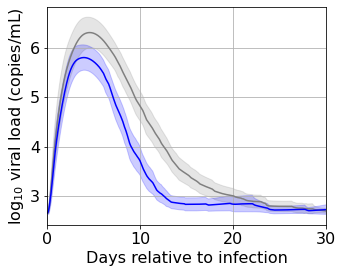

In [142]:
LLOQ = 10**np.min(data_df.y)
data = np.log10(np.maximum(V_,LLOQ))
PlotMeanWithCI(data,reinfections_df, xlims = [0,30], ylabel = r'log$_{10}$ viral load (copies/mL)')

(2) Refractory and susceptible target cells

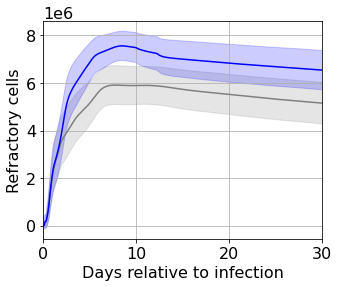

In [144]:
data = R_
PlotMeanWithCI(data,reinfections_df, xlims = [0,30], ylabel = 'Refractory cells')

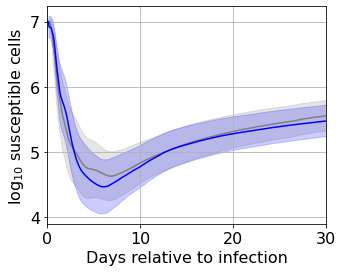

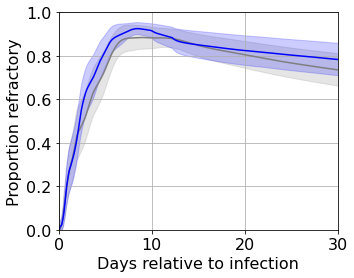

In [153]:
data = np.log10(S_)
PlotMeanWithCI(data,reinfections_df, xlims = [0,30], ylabel = r'log$_{10}$ susceptible cells')
data = R_/(R_+S_)
PlotMeanWithCI(data,reinfections_df, xlims = [0,30], ylims = [0,1], ylabel = r'Proportion refractory')

(3) Density-dependent clearance of infected cells

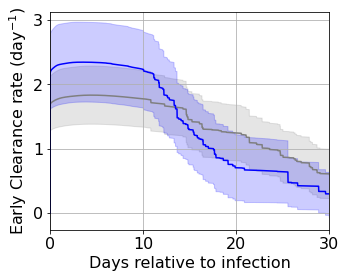

In [157]:
data = [delta*np.maximum(I,1e-16)**h*(I>1e-7) for (delta,I,h) in zip(reinfections_df['delta_mode'],I_,reinfections_df['h_mode'])] 
data = np.concatenate(data)
data = np.reshape(data, (len(reinfections_df),5000))
PlotMeanWithCI(data,reinfections_df, xlims = [0,30], ylabel = 'Early Clearance rate (day$^{-1}$)')

(4) Time-dependent clearance of infected cells.

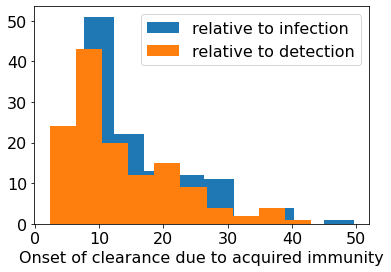

In [165]:
adjusted_tAI = [t0+tAI for t0,tAI in zip(reinfections_df.tzero_mode,reinfections_df.tAI_mode)]
plt.hist(adjusted_tAI , label ='relative to infection')
plt.hist(reinfections_df.tAI_mode, label = 'relative to detection')
reinfections_df['Adjusted_tAI'] = adjusted_tAI
plt.xlabel('Onset of clearance due to acquired immunity')
plt.legend()

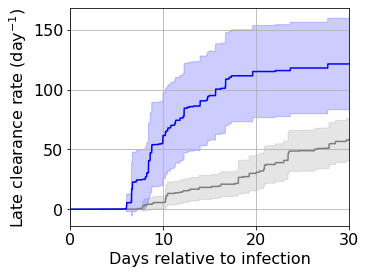

In [168]:
data = [m*1*(t > tadj) for (m,tadj) in zip(reinfections_df['m_mode'],reinfections_df['Adjusted_tAI'])] 
data = np.concatenate(data)
data = np.reshape(data, (len(reinfections_df),5000))
PlotMeanWithCI(data,reinfections_df, xlims = [0,30], ylabel = 'Late clearance rate (day$^{-1}$)')

### Differences in estimated parameter values

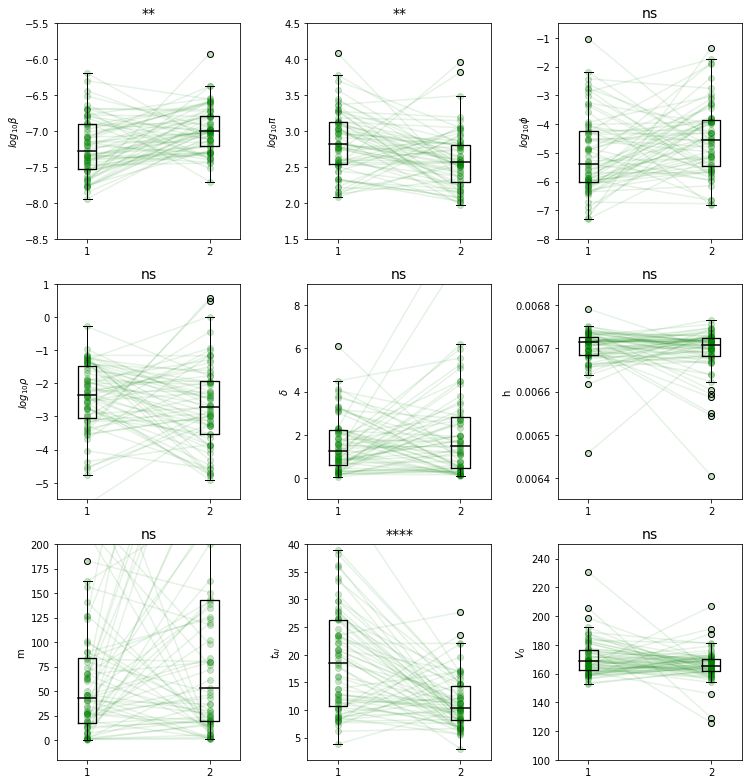

In [177]:
# -- All parameters

fig = plt.figure(figsize = (10.5,11))
ylims = [[-8.5,-5.5],[1.5,4.5],[-8,-0.5],[-5.5,1], [-1,9],[.00635,.00685], [-20,200],[1,40],[100, 250]]
ylabels = [r'$log_{10}\beta$', r'$log_{10}\pi$', r'$log_{10}\phi$',r'$log_{10}\rho$', r'$\delta$','h','m',r'$t_{AI}$', r'$V_0$']
for i,f in enumerate(['log10beta_mode', 'log10pi_mode', 'log10phi_mode','log10rho_mode', 'delta_mode','h_mode','m_mode','Adjusted_tAI','V0_mode']):
    fig.add_subplot(331+i)
    plt.ylabel(ylabels[i])
    for ii, p in enumerate(pids):
        df1 = reinfections_df[reinfections_df.id == p+'_1'].copy()
        df2 = reinfections_df[reinfections_df.id == p+'_2'].copy()
        xdata = [1,2]
        ydata = [list(df1[f])[0], list(df2[f])[0]]
        plt.plot(xdata,ydata, '-', alpha = 0.1, color = 'green')
        plt.plot(xdata,ydata, 'o', alpha = 0.2, color = 'green')
    all_data = []
    labels = ['1', '2']
    for ii,l in enumerate(labels):
        temp = reinfections_df[reinfections_df.ReinfectionFlag == ii+1][f]
        y = temp.tolist()
        x = ii
        all_data.append(y)
    boxprops = dict(color="black",linewidth=1.3)
    medianprops = dict(color="black",linewidth=1.5)
    plt.boxplot(all_data, labels=labels,boxprops=boxprops,medianprops=medianprops);
    plt.xlim([.75, 2.25])
    plt.ylim(ylims[i])
    t = mannwhitneyu(all_data[1], all_data[0]).pvalue
    bc = 9
    if t > 0.05/bc:
        stat = 'ns'
        plt.title(stat, fontsize = 14)
    elif t > .01/bc:
        stat = '*'
        plt.title(stat, fontsize = 14)
    elif t > 1e-3/bc:
        stat = '**'
        plt.title(stat, fontsize = 14)
    elif t > 1e-4/bc:
        stat = '***'
        plt.title(stat, fontsize = 14)
    else:
        stat = '****'
        plt.title(stat, fontsize = 14)

         
plt.tight_layout()

log10beta_mode : stat =  1427.0 pvalue_corrected =  0.002496423060642217
log10pi_mode : stat =  3001.0 pvalue_corrected =  0.0069110782656494636
Adjusted_tAI : stat =  3361.0 pvalue_corrected =  6.148990730070713e-06


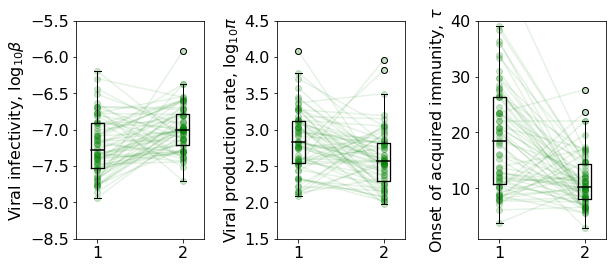

In [181]:
# --- parameters that are different upon reinfection

plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize = (8.8,3.9))
ylims = [[-8.5,-5.5],[1.5,4.5],[1,40]]
ylabels = [r'Viral infectivity, log$_{10}\beta$', r'Viral production rate, log$_{10}\pi$',  r'Onset of acquired immunity, $\tau$']
for i,f in enumerate(['log10beta_mode', 'log10pi_mode','Adjusted_tAI']):
    fig.add_subplot(131+i)
    plt.ylabel(ylabels[i])
    for ii, p in enumerate(pids):
        df1 = reinfections_df[reinfections_df.id == p+'_1'].copy()
        df2 = reinfections_df[reinfections_df.id == p+'_2'].copy()
        xdata = [1,2]
        ydata = [list(df1[f])[0], list(df2[f])[0]]
        plt.plot(xdata,ydata, '-', alpha = 0.1, color = 'green')
        plt.plot(xdata,ydata, 'o', alpha = 0.2, color = 'green')
    all_data = []
    labels = ['1', '2']
    for ii,l in enumerate(labels):
        temp = reinfections_df[reinfections_df.ReinfectionFlag == ii+1][f]
        y = temp.tolist()
        x = ii
        all_data.append(y)
    output = mannwhitneyu(all_data[0], all_data[1])
    print(f, ': stat = ', str(output.statistic), 'pvalue_corrected = ', str(output.pvalue*bc))
    boxprops = dict(color="black",linewidth=1.3)
    medianprops = dict(color="black",linewidth=1.5)
    plt.boxplot(all_data, labels=labels,boxprops=boxprops,medianprops=medianprops);
    plt.xlim([.75, 2.25])
    plt.ylim(ylims[i])
plt.tight_layout()